In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras import Model
from glob import glob
import os
import pathlib
import random

### Step1: Becoming one with data

* lets understand how our data is present

In [86]:
## walk through the data directory and list the number of files

for dirpath, dirnames, filename in os.walk("Datasets"):
    print(f"There are {len(dirnames)} directories and {len(filename)} files in {dirpath}")

There are 2 directories and 0 files in Datasets
There are 3 directories and 0 files in Datasets\Test
There are 0 directories and 9 files in Datasets\Test\audi
There are 0 directories and 30 files in Datasets\Test\lamborghini
There are 0 directories and 19 files in Datasets\Test\mercedes
There are 3 directories and 0 files in Datasets\Train
There are 0 directories and 20 files in Datasets\Train\audi
There are 0 directories and 19 files in Datasets\Train\lamborghini
There are 0 directories and 25 files in Datasets\Train\mercedes


In [87]:
# number of train images in data
audi_count = len(os.listdir("Datasets/Train/audi"))
lamborghini_count = len(os.listdir("Datasets/Train/lamborghini/"))
mercedes_count = len(os.listdir("Datasets/Train/mercedes/"))
print(f"There are {audi_count} audi images")
print(f"There are {lamborghini_count} lamborghini images")
print(f"There are {mercedes_count} mercedes images")

There are 20 audi images
There are 19 lamborghini images
There are 25 mercedes images


In [88]:
# let's get the class names programatically
class_names = []
data_dir = pathlib.Path("Datasets//Train")
for item in data_dir.glob('*'):
    class_names.append(item.name)
class_names = np.array(class_names)
print(class_names)

['audi' 'lamborghini' 'mercedes']


In [89]:
type(class_names)

numpy.ndarray

### 2. visualize the data

In [90]:
def visualize_data(train_directory, target_class):
    target_folder = train_directory + target_class
    
    # picking up a random image
    image = random.sample(os.listdir(target_folder), 1)
    image = image[0]
    
    img = plt.imread(target_folder + "/" + image)
    plt.imshow(img)                
    plt.show()

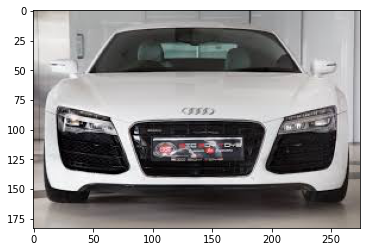

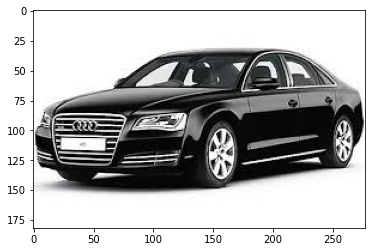

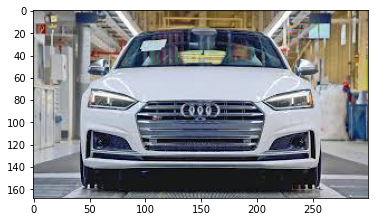

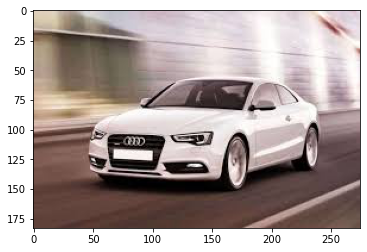

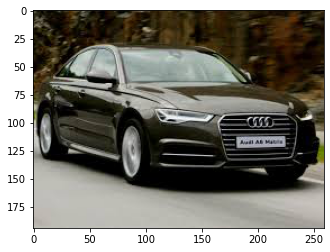

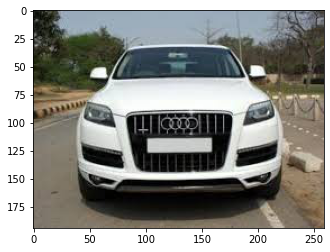

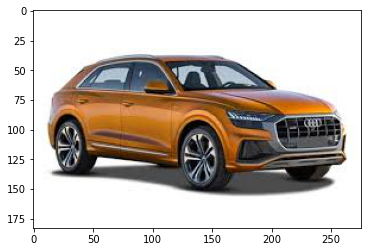

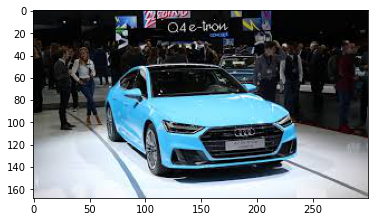

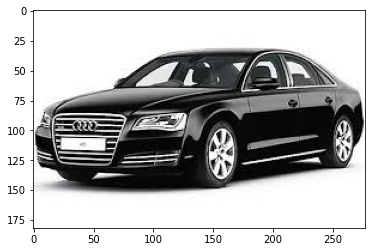

In [91]:
for i in range(10):
    img = visualize_data("Datasets/Train/", "audi")

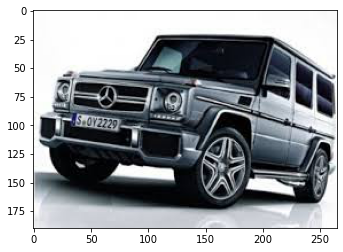

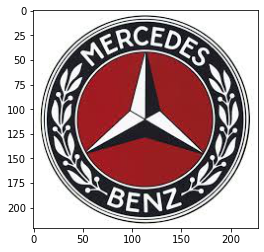

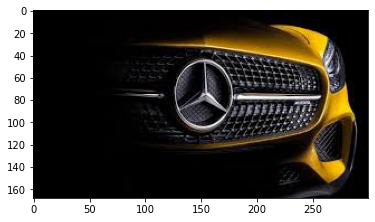

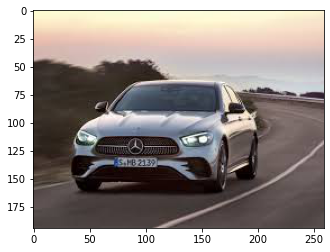

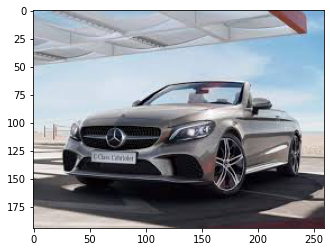

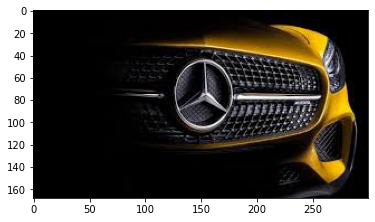

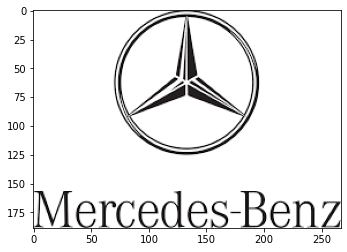

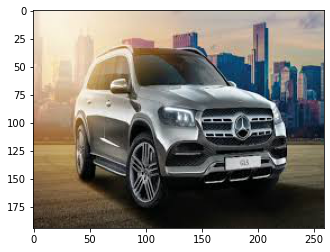

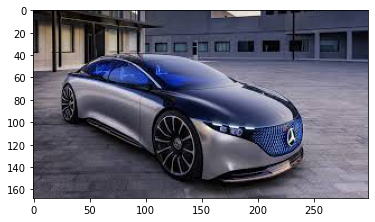

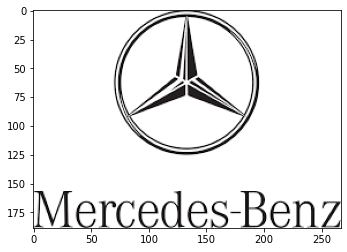

In [92]:
for i in range(10):
    img = visualize_data("Datasets/Train/", "mercedes")

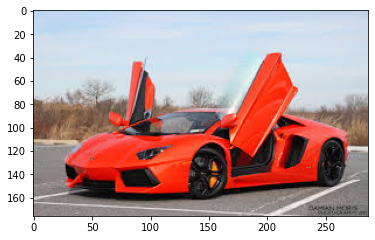

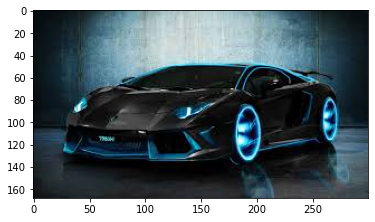

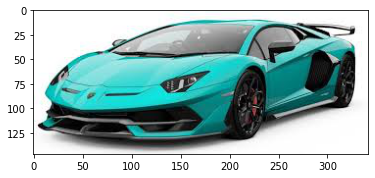

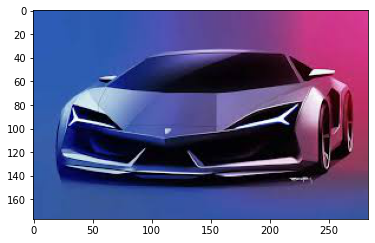

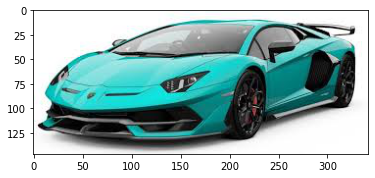

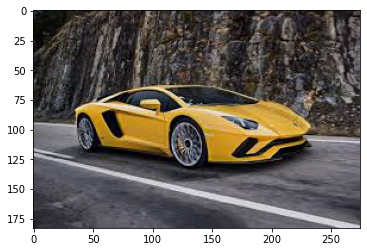

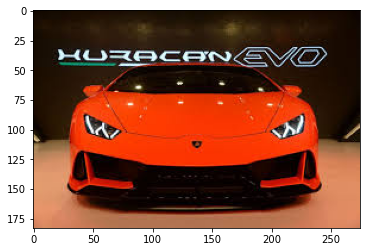

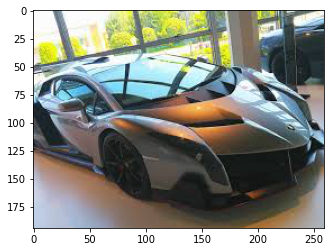

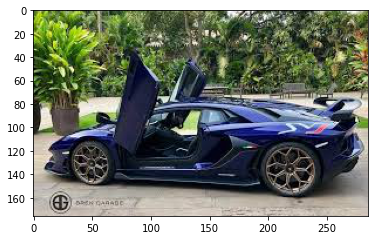

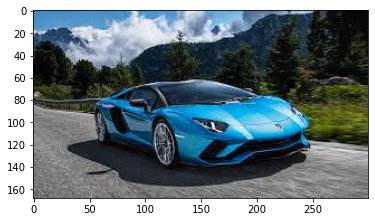

In [93]:
for i in range(10):
    img = visualize_data("Datasets/Train/", "lamborghini")

### Data preprocessing

In [94]:
# resize all the image to this
IMAGE_SIZE = [224, 224]
train_dir = "Datasets/Train"
test_dir = "Datasets/Test"
[224, 224] + [3]

[224, 224, 3]

In [95]:
## Impport the Resnet library as shown below and add preprocessing layer to front of vgg

resnet = ResNet50(input_shape= IMAGE_SIZE + [3],
                 weights="imagenet",
                 include_top=False) 

In [96]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [97]:
# DOn't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [98]:
# getting the number of output classes
folders = glob('Datasets/Train/*')
print(folders)

['Datasets/Train\\audi', 'Datasets/Train\\lamborghini', 'Datasets/Train\\mercedes']


In [99]:
## adding our end layers to resnet
X = Flatten()(resnet.output)
prediction = Dense(len(folders), activation="softmax")(X)
model = Model(inputs=resnet.input, outputs=prediction)

In [100]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

conv3_block2_3_conv (Conv2D)    (None, 28, 28, 512)  66048       conv3_block2_2_relu[0][0]        
__________________________________________________________________________________________________
conv3_block2_3_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block2_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block2_add (Add)          (None, 28, 28, 512)  0           conv3_block1_out[0][0]           
                                                                 conv3_block2_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block2_out (Activation)   (None, 28, 28, 512)  0           conv3_block2_add[0][0]           
__________________________________________________________________________________________________
conv3_block3_1_conv (Conv2D)    (None, 28, 28, 128)  65664       conv3_block2_out[0][0]           
__________

#### WE can observe that we have added our flatten and output Dense layer with softmax activation to the end of Resnet50 model

In [101]:
# compiling the model
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [102]:
# use the ImageDatagenerator to import images from dataset

train_datagen_augmented = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    dtype=None)

# make sure to provide the same target size as initialized in the model
training_set_augmented = train_datagen_augmented.flow_from_directory('Datasets/Train',
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                shuffle=False)

# non augmented training data
train_datagen = ImageDataGenerator(rescale=1./255)
training_set = train_datagen.flow_from_directory('Datasets/Train',
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                shuffle=False)

Found 64 images belonging to 3 classes.
Found 64 images belonging to 3 classes.


In [103]:
images, labels = training_set.next()
print(len(images))
augment_images, augment_labels = training_set_augmented.next()
print(len(images))

32
32


##### We are getting a total of 32 images in each of training and augmented images because we have initialized batch size to 32 and im flow_from directory we have given shuffle = false because we want to compare augmented and original images

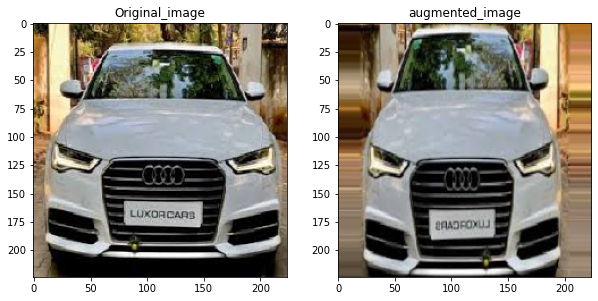

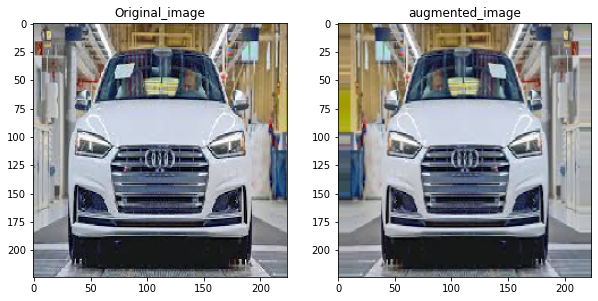

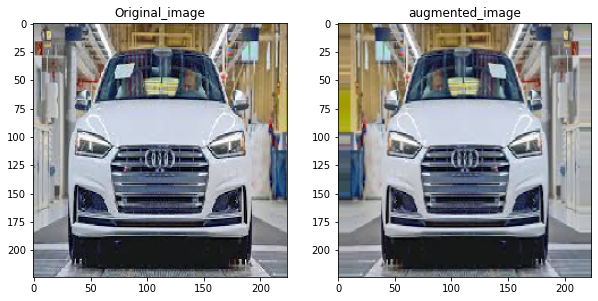

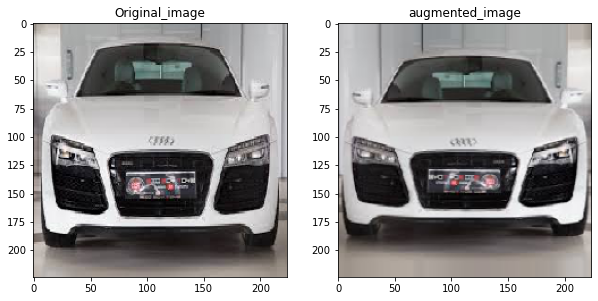

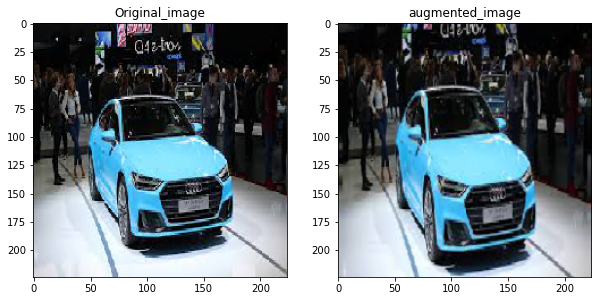

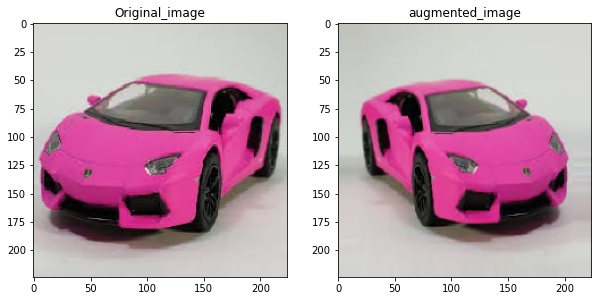

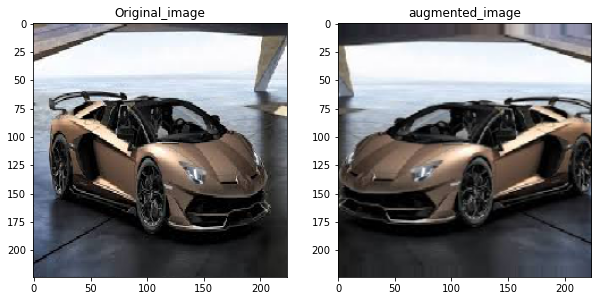

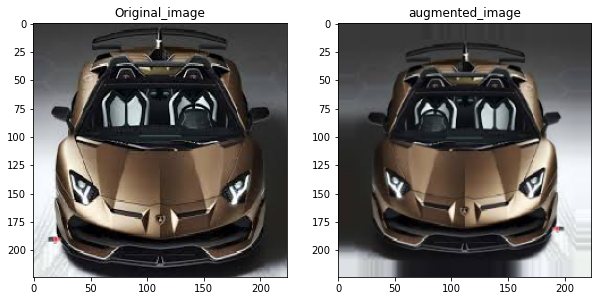

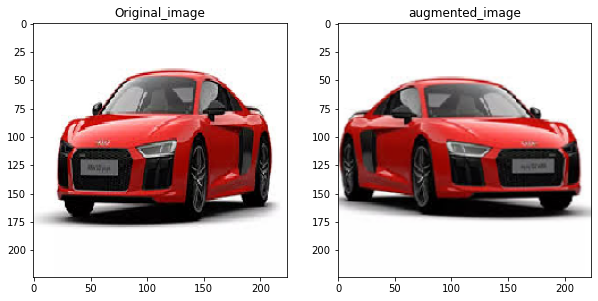

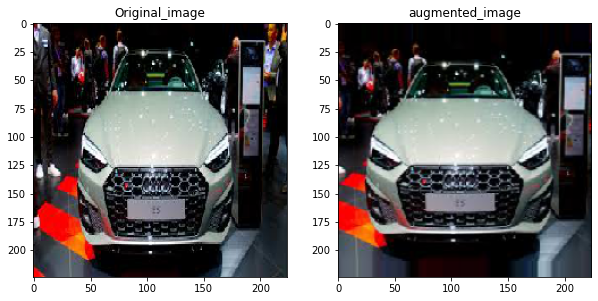

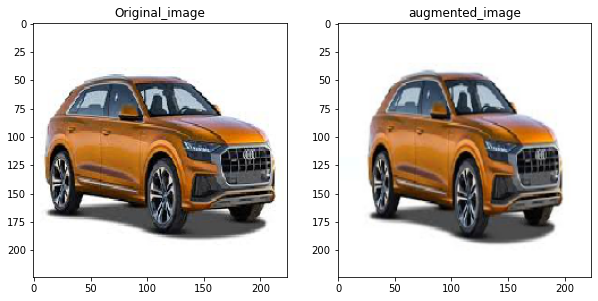

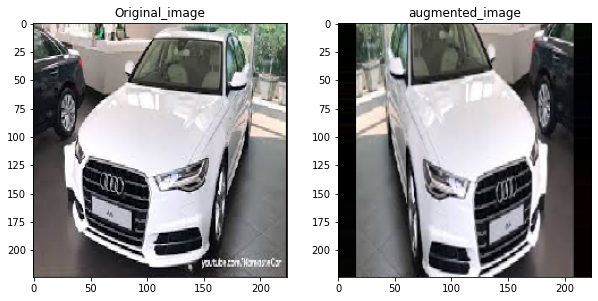

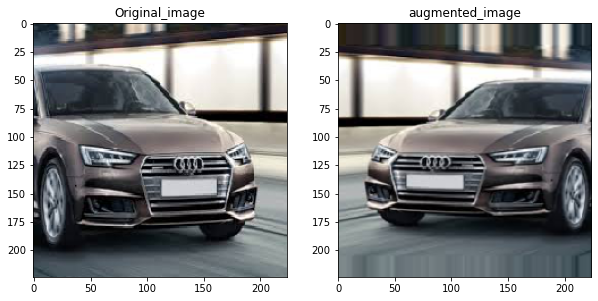

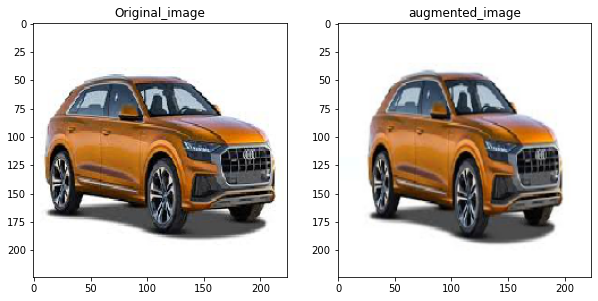

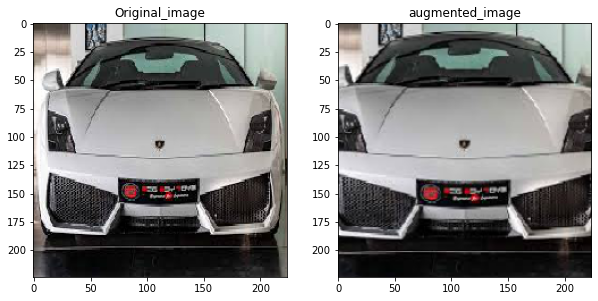

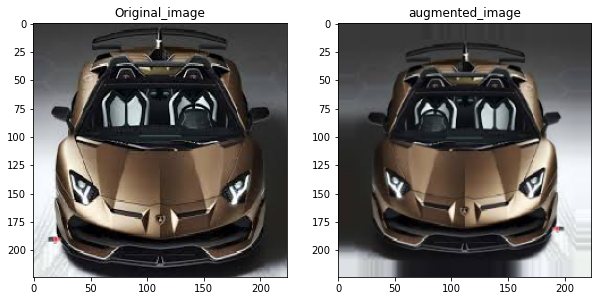

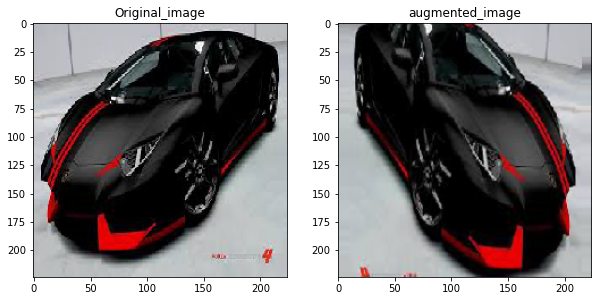

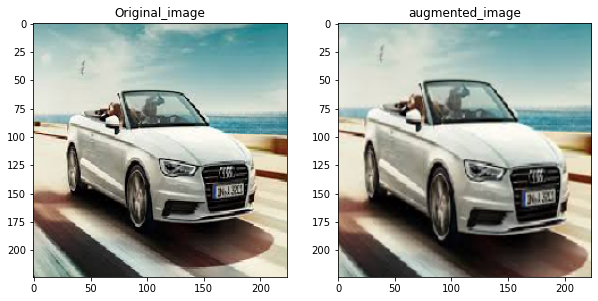

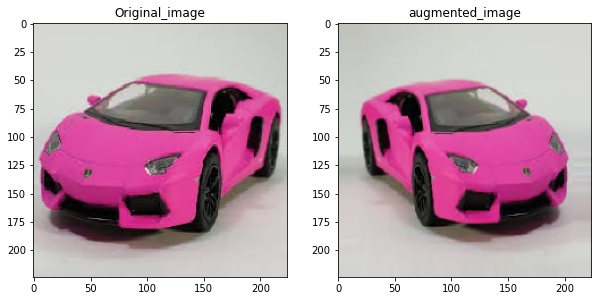

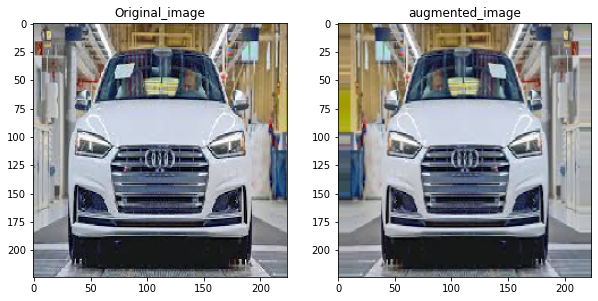

In [104]:
def show_comparision():
    random_number = random.randint(0,32)
    plt.figure(figsize=[10,5])
    plt.subplot(1,2,1)
    plt.imshow(images[random_number])
    plt.title("Original_image")
    
    plt.subplot(1,2,2)
    plt.imshow(augment_images[random_number])
    plt.title("augmented_image")
for i in range(20):
    show_comparision()

In [105]:
### now let's prepare data to be fitted for our model
train_datagen_augmented = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    dtype=None)

# make sure to provide the same target size as initialized in the model
training_set_augmented = train_datagen_augmented.flow_from_directory('Datasets/Train',
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                shuffle=True)

test_data_gen = ImageDataGenerator(rescale=1./255)
test_data = test_data_gen.flow_from_directory(test_dir,
                                             target_size=(224,224),
                                             batch_size=32,
                                             class_mode='categorical',
                                             shuffle=True)


Found 64 images belonging to 3 classes.
Found 58 images belonging to 3 classes.


In [113]:
model1 = model.fit_generator(training_set_augmented,
                   epochs=25,
                   steps_per_epoch=len(training_set_augmented),
                   validation_data=test_data,
                   validation_steps=len(test_data))

Epoch 1/25
2/2 [==============================] - 1s 390ms/step - loss: 0.5286 - accuracy: 0.8125 - val_loss: 1.0324 - val_accuracy: 0.6724
Epoch 2/25
2/2 [==============================] - 1s 367ms/step - loss: 0.3275 - accuracy: 0.8750 - val_loss: 0.9265 - val_accuracy: 0.6897
Epoch 3/25
2/2 [==============================] - 1s 426ms/step - loss: 0.4346 - accuracy: 0.8125 - val_loss: 0.8845 - val_accuracy: 0.6724
Epoch 4/25
2/2 [==============================] - 1s 374ms/step - loss: 0.2949 - accuracy: 0.8906 - val_loss: 0.9079 - val_accuracy: 0.6897
Epoch 5/25
2/2 [==============================] - 1s 381ms/step - loss: 0.3110 - accuracy: 0.9062 - val_loss: 0.9357 - val_accuracy: 0.7069
Epoch 6/25
2/2 [==============================] - 1s 373ms/step - loss: 0.3483 - accuracy: 0.8750 - val_loss: 0.8907 - val_accuracy: 0.7069
Epoch 7/25
2/2 [==============================] - 1s 428ms/step - loss: 0.3417 - accuracy: 0.8594 - val_loss: 0.8582 - val_accuracy: 0.7069
Epoch 8/25
2/2 [====

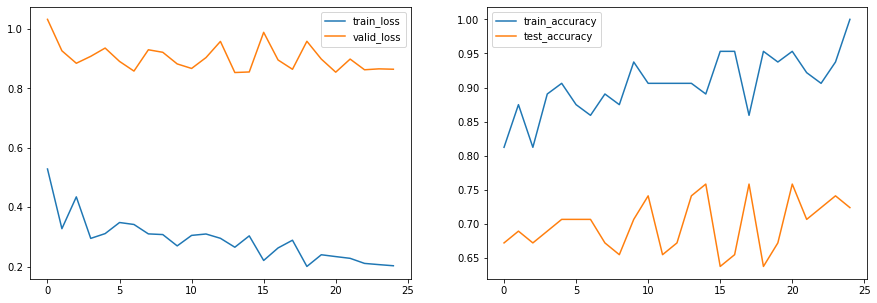

In [114]:
def plot_curve(history):
    train_loss = history.history['loss']
    valid_loss = history.history['val_loss']
    
    train_accuracy = history.history['accuracy']
    test_accuracy = history.history['val_accuracy']
    
    epochs = range(len(train_loss))
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, valid_loss, label='valid_loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.legend()
    
plot_curve(model1)

In [115]:
### validating the model
y_pred = model.predict(test_data)
y_pred

array([[1.52655193e-05, 3.77291930e-04, 9.99607503e-01],
       [4.85506328e-03, 3.67505066e-02, 9.58394408e-01],
       [9.24456585e-03, 9.30394471e-01, 6.03609569e-02],
       [7.92366922e-01, 2.01941907e-01, 5.69119770e-03],
       [2.00020801e-02, 5.54998279e-01, 4.24999624e-01],
       [4.15009260e-02, 3.16626369e-03, 9.55332756e-01],
       [8.96473169e-01, 7.41745457e-02, 2.93522719e-02],
       [5.82097936e-03, 9.62311089e-01, 3.18680182e-02],
       [3.49581577e-02, 3.38773563e-04, 9.64703023e-01],
       [1.64120093e-01, 6.43782914e-01, 1.92097008e-01],
       [4.89461645e-02, 7.67019242e-02, 8.74351859e-01],
       [5.65149076e-03, 5.35231590e-01, 4.59116936e-01],
       [3.86622138e-02, 6.88556135e-01, 2.72781640e-01],
       [1.43411547e-01, 6.22361720e-01, 2.34226704e-01],
       [1.58100377e-03, 9.92808819e-01, 5.61023643e-03],
       [9.74334836e-01, 1.47626335e-02, 1.09024728e-02],
       [7.52182081e-02, 1.51133863e-02, 9.09668386e-01],
       [1.88840494e-01, 5.17106

In [116]:
model.evaluate(test_data)

2/2 [==============================] - 0s 79ms/step - loss: 0.8644 - accuracy: 0.7241


[0.8644327521324158, 0.7241379022598267]

In [117]:
y_pred = tf.argmax(y_pred,axis=1)
y_pred

<tf.Tensor: shape=(58,), dtype=int64, numpy=
array([2, 2, 1, 0, 1, 2, 0, 1, 2, 1, 2, 1, 1, 1, 1, 0, 2, 1, 1, 0, 0, 1,
       2, 2, 1, 2, 1, 0, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1,
       1, 2, 1, 0, 2, 2, 2, 1, 1, 0, 1, 1, 2, 1], dtype=int64)>

In [127]:
## Testing the model with custom images

def load_prep_image(filename, img_shape=224):
    '''reads images and turns to tensor'''
    img = tf.io.read_file(filename)
    # Decode the read file to tensor
    img = tf.image.decode_jpeg(img)
    # resize the image
    img = tf.image.resize(img, size=[img_shape, img_shape])
    # rescale the image
    img = img/255.
    return img
def pred_and_plot(model, filename, classnames=class_names):
    img = load_prep_image(filename)
    pred = model.predict(tf.expand_dims(img, axis=0))
    pred_class = class_names[int(tf.round(pred))]
    
    # plot the image and predicted class
    plt.imshow(img)
    plt.title(f"prediction {pred_class}")
    plt.axis("off")

In [130]:
pred_and_plot(model, '1.jpeg')

TypeError: only size-1 arrays can be converted to Python scalars